<a href="https://colab.research.google.com/github/mariajmolina/UMDAOSC650/blob/main/firstrnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM

An example using ONI (Oceanic Nino Index).

Let's predict a future ONI value using four previous values.

First, we will tackle a Many (4 input time steps) to One (1 future time step) framework.

Second, we will tackle a Many (4 input time steps) to Many (Y future time steps) framework. The Many-to-Many framework does not need to be Tx==Ty (but can be).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, TimeDistributed, RepeatVector
#from keras.src.preprocessing.sequence import TimeseriesGenerator # old timeseries generator
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# reading dataset from NOAA
dataset = pd.read_csv(
    'http://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt',
    sep='\s+')

In [3]:
# data features include seasons, year, total SST (C), and ONI (ENSO index)
dataset.head()

,SEAS,YR,TOTAL,ANOM
0,DJF,1950,24.72,-1.53
1,JFM,1950,25.17,-1.34
2,FMA,1950,25.75,-1.16
3,MAM,1950,26.12,-1.18
4,AMJ,1950,26.32,-1.07


In [4]:
dataset.tail()

,SEAS,YR,TOTAL,ANOM
896,ASO,2024,26.55,-0.21
897,SON,2024,26.45,-0.26
898,OND,2024,26.30,-0.37
899,NDJ,2024,26.09,-0.53
900,DJF,2025,25.99,-0.64


In [5]:
# drop any nans
dataset = dataset.dropna(subset=["ANOM"])

In [6]:
# quick stats
dataset.describe()

,YR,TOTAL,ANOM
count,901.000000,901.000000,901.000000
mean,1987.042175,26.904517,0.012908
std,21.685694,0.943686,0.836209
min,1950.000000,24.380000,-2.030000
25%,1968.000000,26.230000,-0.570000
50%,1987.000000,26.950000,-0.050000
75%,2006.000000,27.540000,0.530000
max,2025.000000,29.260000,2.640000


<Axes: xlabel='YR'>

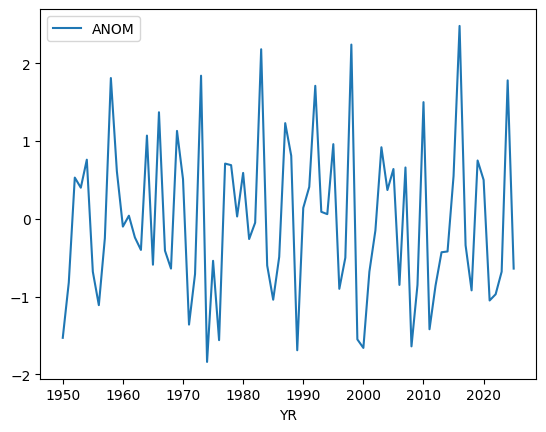

In [7]:
# quick viz
# djf only
dataset[dataset["SEAS"]=="DJF"].plot("YR","ANOM")

In [8]:
# train test split by years
trainds = dataset[dataset["YR"]<=2010]
testsds = dataset[dataset["YR"]>2010]

In [9]:
# grab anoms columns (ONI) and reset index
# reshape to be (samples, features)
# number of features here is just 1 (ONI)
trainds = trainds.reset_index(drop=True)["ANOM"].values.reshape(-1, 1)
testsds = testsds.reset_index(drop=True)["ANOM"].values.reshape(-1, 1)

In [10]:
# checking shapes -- make sure (samples, features)
print(trainds.shape, testsds.shape)

(732, 1) (169, 1)


In [11]:
# Feature Scaling
sc = MinMaxScaler(feature_range=(0,1))

In [12]:
# do rescaling
trainds_scaled = sc.fit_transform(trainds)
testsds_scaled = sc.transform(testsds)

# Why do we need a time series generator for RNNs?

In [13]:
# for help with data manipulation for time series rnn training; we can use the time series generator from keras

# dummy input for understanding
data = np.array([[i] for i in range(100)])

n_input=4 # the length of the input sequence
n_features=1 # the number of features

# here we are using the input to predict the next value(s) in the sequence (many-to-one)
# in other words, the input and target are the same data source
# but we don't have to deal with separating them, the generator does this for us!
inpdata = data[:-n_input]
outdata = data[n_input:]

# check shapes
print(inpdata.shape, outdata.shape)
print(inpdata[:4])
print(outdata[:4])

(96, 1) (96, 1)
[[0]
 [1]
 [2]
 [3]]
[[4]
 [5]
 [6]
 [7]]


In [14]:
# For many-to-one, we can set the timeseries generator to have different
# data and targets as below
data_gen = keras.utils.timeseries_dataset_from_array(
    data=inpdata,
    targets=outdata,
    sequence_length=4, # Length of the data sequences
    sequence_stride=5, # Period between successive output sequences
    sampling_rate=1,   # Period between successive individual timesteps (problematic if > 1)
    batch_size=3,
    shuffle=False,
    seed=1,
    start_index=None,
    end_index=None,
)

In [15]:
for batch in data_gen:
  inputs, targets = batch
  print(f"Inputs: {inputs}")
  print(f"Targets: {targets}")
  break

Inputs: [[[ 0]
  [ 1]
  [ 2]
  [ 3]]

 [[ 5]
  [ 6]
  [ 7]
  [ 8]]

 [[10]
  [11]
  [12]
  [13]]]
Targets: [[ 4]
 [ 9]
 [14]]


In [16]:
# For many-to-many, we can set the timeseries generator to have no targets

# dummy input for understanding
data = np.array([[i] for i in range(100)])

# Example1: Lx = Ly (concurrent output)
#sequence_length_inp = 4
#sequence_length_out = sequence_length_inp
#start_index_out = None
#sequence_stride = 1
#sampling_rate = 1

# Example2: Lx = Ly (input sequence, wait, output sequence)
sequence_length_inp = 4
sequence_length_out = 3
start_index_out = sequence_length_inp
sequence_stride = 1
sampling_rate = 1

# Example3: Lx = Ly (input sequence and slide output sequence)
#sequence_length_inp = 4
#sequence_length_out = sequence_length_inp
#start_index_out = 2
#sequence_stride = start_index_out
#sampling_rate = start_index_out

# data generators
data_gen_inp = keras.utils.timeseries_dataset_from_array(
    data=data,
    targets=None,
    sequence_length=sequence_length_inp, # Length of the data sequences
    sequence_stride=sequence_stride, # Adjust this to slide the output sequence from the input sequence
    sampling_rate=sampling_rate,   # Period between successive individual timesteps
    batch_size=2,
    shuffle=False,
    seed=1,
    start_index=None,
    end_index=None,
)

data_gen_out = keras.utils.timeseries_dataset_from_array(
    data=data,
    targets=None,
    sequence_length=sequence_length_out, # Length of the data sequences
    sequence_stride=sequence_stride, # Adjust this to slide the output sequence from the input sequence
    sampling_rate=sampling_rate,   # Period between successive individual timesteps
    batch_size=2,
    shuffle=False,
    seed=1,
    start_index=start_index_out,
    end_index=None,
)

In [17]:
# quick check of output
for inputs, outputs in zip(data_gen_inp, data_gen_out):
  print(f"Inputs: {inputs}")
  print(f"Targets: {outputs}")
  break

Inputs: [[[0]
  [1]
  [2]
  [3]]

 [[1]
  [2]
  [3]
  [4]]]
Targets: [[[4]
  [5]
  [6]]

 [[5]
  [6]
  [7]]]


# Many-to-One LSTM
(Process one time step at a time and only output the final hidden state)

This approach is often used when you are primarily interested in the overall context of the sequence for making a single prediction at the end.

In [18]:
# the length of the input feature
n_input = 4 # you can change this! doesn't HAVE to be 4 months input

# here goes our training data
inpdata = trainds_scaled[:-n_input]
outdata = trainds_scaled[n_input:]

n_features = 1
BATCHSIZE = 16

data_gen = keras.utils.timeseries_dataset_from_array(
    data=inpdata,
    targets=outdata,
    sequence_length=4, # Length of the data sequences
    sequence_stride=1, # Period between successive output sequences
    sampling_rate=1,   # Period between successive individual timesteps (problematic if > 1)
    batch_size=BATCHSIZE,
    shuffle=False,
    seed=1,
    start_index=None,
    end_index=None,
)

# generators make using validation_split not possible when training, we need to define one now
test_gen = keras.utils.timeseries_dataset_from_array(
    data=testsds_scaled[:-n_input],
    targets=testsds_scaled[n_input:],
    sequence_length=4, # Length of the data sequences
    sequence_stride=1, # Period between successive output sequences
    sampling_rate=1,   # Period between successive individual timesteps (problematic if > 1)
    batch_size=len(testsds_scaled[n_input:]),
    shuffle=False,
    seed=1,
    start_index=None,
    end_index=None,
)

In [19]:
# check shapes
print(inpdata.shape, outdata.shape, n_features)

(728, 1) (728, 1) 1


In [20]:
for batch in data_gen:
  inputs, targets = batch
  print(f"Inputs: {inputs[0:3]}")
  print(f"Targets: {targets[0:3]}")
  break

Inputs: [[[0.11286682]
  [0.15575621]
  [0.19638826]
  [0.19187359]]

 [[0.15575621]
  [0.19638826]
  [0.19187359]
  [0.21670429]]

 [[0.19638826]
  [0.19187359]
  [0.21670429]
  [0.26636569]]]
Targets: [[0.21670429]
 [0.26636569]
 [0.33634312]]


In [21]:
# many-to-one example
# lets make our rnn!
regressor = Sequential()

# LSTM; input shape is 1 (for one time step at a time)
# and n_features which is also 1 for our toy example
regressor.add(keras.layers.Input(shape=(1, n_features), batch_size=BATCHSIZE))

### NOTE BELOW:
# If you want to process the entire sequence at once, change the input
# shape above to (4, n_features) while keeping return_sequences=False below.

# don't return sequence; just the final hidden state
regressor.add(LSTM(units=50, return_sequences=False))

# one neuron for output prediction
regressor.add(Dense(1))
regressor.add(Activation('linear'))

# compile model
regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

Why Can You Use Different Shapes for the Input Layer?

*   Incremental Memory Update (Shape (1, n_features)): This approach allows the LSTM to update its internal state step-by-step, which can be useful if the temporal dependencies are complex and need to be captured gradually (but is less efficient).
*   Full Sequence Processing (Shape (4, n_features)): This allows the LSTM to capture dependencies across the entire sequence simultaneously, which can be more efficient and may lead to better performance if the model can effectively use the context, but may not capture gradual dependencies as effectively as processing one step at a time.

In [22]:
# what does graph look like?
regressor.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (16, 50)                    │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (16, 1)                     │              51 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (16, 1)                     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# train the lstm!
EPOCHS = 20
history = regressor.fit(data_gen, epochs=EPOCHS, validation_data=test_gen)

Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0976 - mae: 0.2653 - mse: 0.0976 - val_loss: 0.0120 - val_mae: 0.0890 - val_mse: 0.0120
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0095 - mae: 0.0752 - mse: 0.0095 - val_loss: 0.0108 - val_mae: 0.0832 - val_mse: 0.0108
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0089 - mae: 0.0732 - mse: 0.0089 - val_loss: 0.0103 - val_mae: 0.0810 - val_mse: 0.0103
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0086 - mae: 0.0719 - mse: 0.0086 - val_loss: 0.0099 - val_mae: 0.0793 - val_mse: 0.0099
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0084 - mae: 0.0710 - mse: 0.0084 - val_loss: 0.0096 - val_mae: 0.0781 - val_mse: 0.0096
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0082 - mae: 0.0702 - mse: 0.0082 - val_loss: 0.0094 - val_mae: 0.0769 - val_mse: 0.0094
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0080 - mae: 0.0694 - mse: 0.0080 - val_loss: 0.00

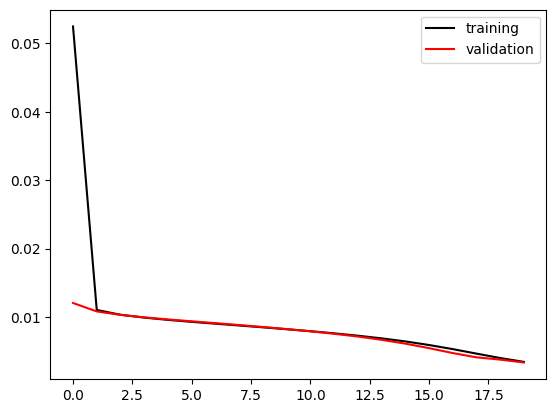

In [24]:
plt.plot(range(0,EPOCHS), history.history['loss'], c='k', label='training')
plt.plot(range(0,EPOCHS), history.history['val_loss'], c='r', label='validation')
plt.legend()
plt.show()

In [25]:
for batch in test_gen:
  _, y = batch
  print(f"Targets: {y.shape}")
  break

Targets: (162, 1)


In [26]:
# predict using test data
oni_predictions = regressor.predict(test_gen)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


In [27]:
# quick check that we have a match of shapes
print(oni_predictions.shape, y.shape)

(162, 1) (162, 1)


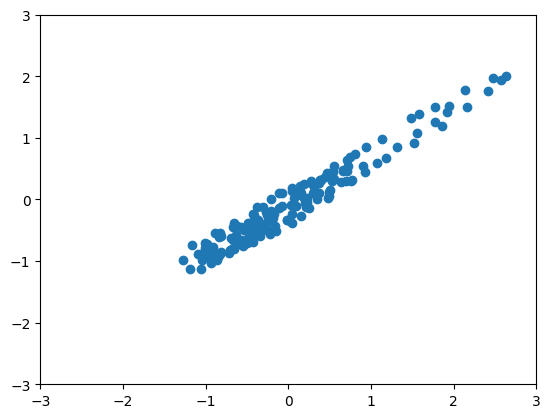

In [28]:
# how did we do!?
plt.scatter(
    sc.inverse_transform(y).reshape(-1),
    sc.inverse_transform(oni_predictions).reshape(-1)
    )
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.show()

# Many-to-Many LSTM

In [29]:
# redoing data preprocessing steps here more quickly

# reading dataset from NOAA online
dataset = pd.read_csv(
    'http://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt',
    sep='\s+')

# drop any nans
dataset = dataset.dropna(subset=["ANOM"])

# train test split by years
trainds = dataset[dataset["YR"]<=2010]
testsds = dataset[dataset["YR"]>2010]

# grab anoms columns (ONI) and reset index
# reshape to be (samples, features)
# number of features here is just 1 (ONI)
trainds = trainds.reset_index(drop=True)["ANOM"].values.reshape(-1, 1)
testsds = testsds.reset_index(drop=True)["ANOM"].values.reshape(-1, 1)

# Feature Scaling
sc = MinMaxScaler(feature_range=(0,1))

# do rescaling
trainds_scaled = sc.fit_transform(trainds)
testsds_scaled = sc.transform(testsds)

In [30]:
inpdata = trainds_scaled
outdata = trainds_scaled
n_features = 1
BATCHSIZE = 16

# For many-to-many, we can set the timeseries generator to have no targets

# Example1: Lx = Ly (concurrent output)
#sequence_length_inp = 4
#sequence_length_out = sequence_length_inp
#start_index_out = None
#sequence_stride = 1
#sampling_rate = 1

# Example2: Lx = Ly (input sequence, wait, output sequence)
sequence_length_inp = 4
sequence_length_out = 3
start_index_out = sequence_length_inp
sequence_stride = 1
sampling_rate = 1

# Example3: Lx = Ly (input sequence and slide output sequence)
#sequence_length_inp = 4
#sequence_length_out = sequence_length_inp
#start_index_out = 2
#sequence_stride = start_index_out
#sampling_rate = start_index_out

# data generators
data_gen_inp = keras.utils.timeseries_dataset_from_array(
    data=inpdata,
    targets=None,
    sequence_length=sequence_length_inp, # Length of the data sequences
    sequence_stride=sequence_stride, # Adjust this to slide the output sequence from the input sequence
    sampling_rate=sampling_rate,   # Period between successive individual timesteps
    batch_size=BATCHSIZE,
    shuffle=False,
    seed=1,
    start_index=None,
    end_index=None,
)

data_gen_out = keras.utils.timeseries_dataset_from_array(
    data=outdata,
    targets=None,
    sequence_length=sequence_length_out, # Length of the data sequences
    sequence_stride=sequence_stride, # Adjust this to slide the output sequence from the input sequence
    sampling_rate=sampling_rate,   # Period between successive individual timesteps
    batch_size=BATCHSIZE,
    shuffle=False,
    seed=1,
    start_index=start_index_out,
    end_index=None,
)

In [31]:
# quick check of output
for inputs, outputs in zip(data_gen_inp, data_gen_out):
  print(f"Inputs: {inputs[:3]}")
  print(f"Targets: {outputs[:3]}")
  break

Inputs: [[[0.11286682]
  [0.15575621]
  [0.19638826]
  [0.19187359]]

 [[0.15575621]
  [0.19638826]
  [0.19187359]
  [0.21670429]]

 [[0.19638826]
  [0.19187359]
  [0.21670429]
  [0.26636569]]]
Targets: [[[0.21670429]
  [0.26636569]
  [0.33634312]]

 [[0.26636569]
  [0.33634312]
  [0.36343115]]

 [[0.33634312]
  [0.36343115]
  [0.37020316]]]


In [32]:
# many-to-many encoder-decoder example

# lets make our rnn!
regressor = Sequential()

# LSTM; the encoder stage treats each time step as an individual input
regressor.add(
    keras.layers.Input(shape=(1, n_features), batch_size=BATCHSIZE)
    )

# encoder is needed because we are using many to predict future manys
# the LSTM layer will only output the final hidden state of the sequence
regressor.add(LSTM(units=50, return_sequences=False))

# repeat the encoder output to create an input sequence for
# the decoder that is of the same length as the desired output sequence
regressor.add(RepeatVector(sequence_length_out))

# decoder to predict;
# In contrast to the encoder, return_sequence is set to True for the decoder
# because we want the LSTM to output a prediction at each time step of the output sequence
regressor.add(LSTM(units=50, return_sequences=True))

# predict 1 value per returned sequence value
# TimeDistributed: apply to the output of the LSTM at each time step, allowing it to
# make a prediction for each step in the output sequence.
regressor.add(TimeDistributed(Dense(1)))
regressor.add(Activation('linear'))

# compile model
regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

# what does graph look like?
regressor.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (16, 50)                    │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (16, 3, 50)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (16, 3, 50)                 │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (16, 3, 1)                  │              51 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (16, 3, 1)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
def combine_generators(gen1, gen2, batch_size_threshold=BATCHSIZE):
  """Combines two generators into one yielding tuples of (inputs, targets)."""
  # Convert the datasets to iterators using iter()
  gen1_iter = iter(gen1)
  gen2_iter = iter(gen2)
  while True:
    try:
      x = next(gen1_iter)  # Get the next batch from the first iterator
      y = next(gen2_iter)  # Get the next batch from the second iterator

      # Check if batch size is below threshold
      if x.shape[0] < batch_size_threshold or y.shape[0] < batch_size_threshold:
        break  # Stop if batch size is too small

      yield x, y  # Yield the combined data
    except StopIteration:
        # Stop when one of the iterators is exhausted
        break

In [34]:
# Combine the input and target data generators
train_data_gen = combine_generators(data_gen_inp, data_gen_out)

In [35]:
EPOCHS = 20
# train the lstm!
history = regressor.fit(
    train_data_gen, epochs=EPOCHS, steps_per_epoch=len(data_gen_inp)
    )

Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.1581 - mae: 0.3496 - mse: 0.1581
Epoch 2/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0307 - mae: 0.1408 - mse: 0.0307 
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0303 - mae: 0.1401 - mse: 0.0303  
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0293 - mae: 0.1374 - mse: 0.0293  
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0277 - mae: 0.1334 - mse: 0.0277 
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0260 - mae: 0.1291 - mse: 0.0260 
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0245 - mae: 0.1259 - mse: 0.0245 
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 0.0233 - mae: 0.1239 - mse: 0.0233 
Epoch 9/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 0.0225 - mae: 0.1224 - mse: 0.0225
Epoch 10/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 0.0219 - mae: 0.1214 - mse: 0.0219
Epoch 11/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0214 - mae: 0.1202 - mse: 0.0214 
Epoch 12/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 634us/step - loss: 0.

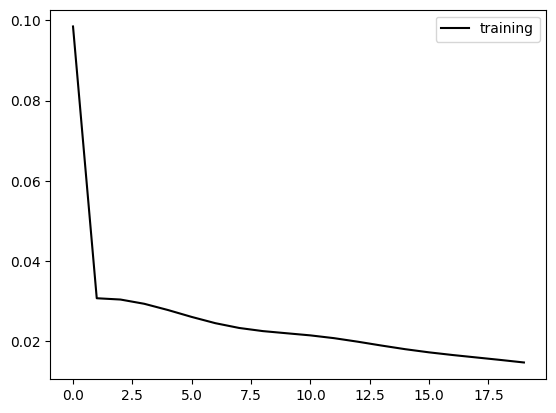

In [36]:
plt.plot(range(0,EPOCHS), history.history['loss'], c='k', label='training')
plt.legend()
plt.show()

In [37]:
# here goes our testing data
inpdata = testsds_scaled
outdata = testsds_scaled
n_features = 1
BATCHSIZE = len(testsds_scaled)

# For many-to-many, we can set the timeseries generator to have no targets

# Example1: Lx = Ly (concurrent output)
#sequence_length_inp = 4
#sequence_length_out = sequence_length_inp
#start_index_out = None
#sequence_stride = 1
#sampling_rate = 1

# Example2: Lx = Ly (input sequence, wait, output sequence)
sequence_length_inp = 4
sequence_length_out = 3
start_index_out = sequence_length_inp
sequence_stride = 1
sampling_rate = 1

# Example3: Lx = Ly (input sequence and slide output sequence)
#sequence_length_inp = 4
#sequence_length_out = sequence_length_inp
#start_index_out = 2
#sequence_stride = start_index_out
#sampling_rate = start_index_out

# data generators
test_gen_inp = keras.utils.timeseries_dataset_from_array(
    data=inpdata,
    targets=None,
    sequence_length=sequence_length_inp, # Length of the data sequences
    sequence_stride=sequence_stride, # Adjust this to slide the output sequence from the input sequence
    sampling_rate=sampling_rate,   # Period between successive individual timesteps
    batch_size=BATCHSIZE,
    shuffle=False,
    seed=1,
    start_index=None,
    end_index=None,
)

test_gen_out = keras.utils.timeseries_dataset_from_array(
    data=outdata,
    targets=None,
    sequence_length=sequence_length_out, # Length of the data sequences
    sequence_stride=sequence_stride, # Adjust this to slide the output sequence from the input sequence
    sampling_rate=sampling_rate,   # Period between successive individual timesteps
    batch_size=BATCHSIZE,
    shuffle=False,
    seed=1,
    start_index=start_index_out,
    end_index=None,
)

In [38]:
# quick check of output
for inputs, outputs in zip(test_gen_inp, test_gen_out):
  print(f"Inputs: {inputs[:3]}")
  print(f"Targets: {outputs[:3]}")
  break

Inputs: [[[0.13769752]
  [0.18961625]
  [0.248307  ]
  [0.29345372]]

 [[0.18961625]
  [0.248307  ]
  [0.29345372]
  [0.33408578]]

 [[0.248307  ]
  [0.29345372]
  [0.33408578]
  [0.35891648]]]
Targets: [[[0.33408578]
  [0.35891648]
  [0.34988713]]

 [[0.35891648]
  [0.34988713]
  [0.31828442]]

 [[0.34988713]
  [0.31828442]
  [0.27088036]]]


In [39]:
for batch in test_gen_out:
  y = batch
  print(f"Targets: {y.shape}")
  break

Targets: (163, 3, 1)


In [40]:
# make predictions
oni_predictions = regressor.predict(test_gen_inp)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


In [41]:
# check shapes match
print(oni_predictions.shape, y.shape)

(166, 3, 1) (163, 3, 1)


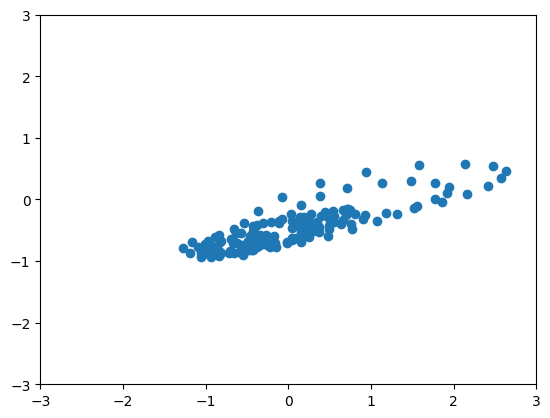

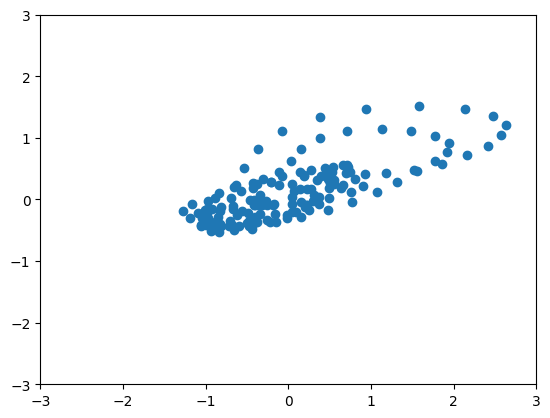

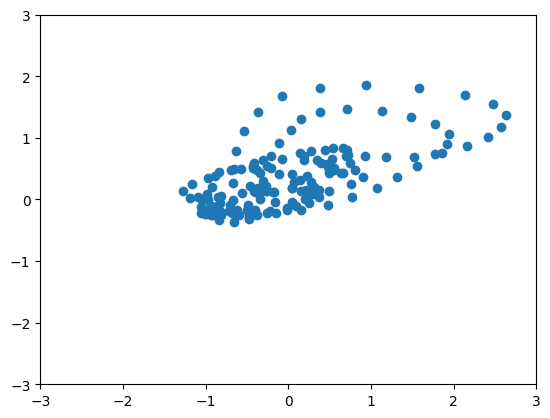

In [42]:
for i in range(0, y.shape[1]):
    # how did we do!?
    plt.scatter(
        sc.inverse_transform(y[:160, i].numpy().reshape(-1, 1)).reshape(-1),
        sc.inverse_transform(oni_predictions[:160, i].reshape(-1, 1)).reshape(-1)
        )
    plt.xlim([-3,3])
    plt.ylim([-3,3])
    plt.show()